<a href="https://colab.research.google.com/github/SDS-AAU/IntroStat/blob/master/Notebooks/AS_Aflevering_2_losning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Open Policing Project

På en typisk dag i USA foretager politibetjente mere end 50 tusind trafikstop. The Stanford Open Policing Project analyserer og deler data fra millioner af trafikstop fra  myndigheder over hele landet. Målet er at hjælpe forskere, journalister og beslutningstagere med at undersøge og forbedre interaktionen mellem politi og offentligheden.

* Du kan læse mere om projektet [her](https://openpolicing.stanford.edu/publications/). 

I denne opgave skal du rekonstruere nogle af de centrale forskningsresultater baseret på de Open Policing Data.
Notebook'en guider dig gennem opgaven. 

* Pierson, E., Simoiu, C., Overgoor, J., Corbett-Davies, S., Jenson, D., Shoemaker, A., Ramachandran, V., Barghouty, P., Phillips, C., Shroff, R. and Goel, S., 2020. A large-scale analysis of racial disparities in police stops across the United States. Nature human behaviour, pp.1-10. [PDF](https://5harad.com/papers/100M-stops.pdf)



Opgaven er allerede delvist løst. Du finder flere nye teknikker introduceret i notebook'en (hints) og koder.
Disse er ikke nødvendigvis en del af pensum, men alligevel nyttige tilføjelser til din værktøjssæt.


In [ ]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/iwOWcuFjNfw" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

In [ ]:
HTML('<iframe width="800" height="315" src="https://openpolicing.stanford.edu/data/" ></iframe>')

Væsentlige pakker er importeret, men du må tilføje og ændre indstillinger (f.eks. Indstille plotningsparametre)

In [ ]:
# import pakker

import pandas as pd
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Indlæsning og indledende databehandling

Data findes her: `https://sds-aau.github.io/IntroStat/Data/RI-clean.csv.gz` det er en komprimeret fil og du skal tilføje `compression='gzip'` som parameter ved indlæsning.
Det er trafikstop fra Rhode Island 2005-2015 - i alt omkring 500.000 observationer.

Skulle der opleves problemer med direkte indlæsning via URL, kan du downloade filer på *moodle*.

In [ ]:
# indlæsning data

data = pd.read_csv('https://sds-aau.github.io/IntroStat/Data/RI-clean.csv.gz', compression='gzip')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Tid og dato kombineres og der defineres en tidsserie-index
combined = data.stop_date.str.cat(data.stop_time, sep=' ')
data['date_and_time'] = pd.to_datetime(combined)


data.set_index('date_and_time', inplace=True)

In [ ]:
# variable-type omkodes til boolean

data[['is_arrested', 'search_conducted']] = data[['is_arrested', 'search_conducted']].astype(bool)

In [ ]:
data.head()

,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location,police_department,driver_gender,driver_age_raw,driver_age,driver_race_raw,driver_race,violation_raw,violation,search_conducted,search_type_raw,search_type,contraband_found,stop_outcome,is_arrested,stop_duration,out_of_state,drugs_related_stop,district
date_and_time,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-01-02 01:55:00,RI-2005-00001,RI,2005-01-02,01:55,Zone K1,NaN,NaN,NaN,600,M,1985.0,20.0,W,White,Speeding,Speeding,False,NaN,NaN,False,Citation,False,0-15 Min,False,False,Zone K1
2005-01-02 20:30:00,RI-2005-00002,RI,2005-01-02,20:30,Zone X4,NaN,NaN,NaN,500,M,1987.0,18.0,W,White,Speeding,Speeding,False,NaN,NaN,False,Citation,False,16-30 Min,False,False,Zone X4
2005-01-04 11:30:00,RI-2005-00003,RI,2005-01-04,11:30,Zone X1,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False,NaN,True,NaN,NaN,False,Zone X1
2005-01-04 12:55:00,RI-2005-00004,RI,2005-01-04,12:55,Zone X4,NaN,NaN,NaN,500,M,1986.0,19.0,W,White,Equipment/Inspection Violation,Equipment,False,NaN,NaN,False,Citation,False,0-15 Min,False,False,Zone X4
2005-01-06 01:30:00,RI-2005-00005,RI,2005-01-06,01:30,Zone X4,NaN,NaN,NaN,500,M,1978.0,27.0,B,Black,Equipment/Inspection Violation,Equipment,False,NaN,NaN,False,Citation,False,0-15 Min,False,False,Zone X4


### Rens manglende data

* identificer de kolonner med det meste manglende data (3 kolonner) og fjern dem
* identificer de kolonner, hvor vi ikke kender tidspunktet for stop, dato eller personlige egenskaber for bilisten. Fjern observationer, hvor disse variabler mangler: Brug `subset=['xxx', 'xxx', 'xxx']` som argument.


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 480584 entries, 2005-01-02 01:55:00 to 2015-12-31 23:48:00
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  480584 non-null  object 
 1   state               480584 non-null  object 
 2   stop_date           480584 non-null  object 
 3   stop_time           480584 non-null  object 
 4   location_raw        480584 non-null  object 
 5   police_department   480584 non-null  object 
 6   driver_gender       480584 non-null  object 
 7   driver_age_raw      480583 non-null  float64
 8   driver_age          478946 non-null  float64
 9   driver_race_raw     480584 non-null  object 
 10  driver_race         480584 non-null  object 
 11  violation_raw       480584 non-null  object 
 12  violation           480584 non-null  object 
 13  search_conducted    480584 non-null  bool   
 14  search_type_raw     17762 non-null   object 
 15  

In [ ]:
# fjerner hele kolonner
data.drop(['county_name', 'county_fips', 'fine_grained_location'], axis='columns', inplace=True)

In [ ]:
# fjerner observationer med manglende data i speciffike variable
data.dropna(subset=['stop_date', 'stop_time', 'driver_gender'], inplace=True)

## Overtrædelser



*   Hvor ofte bliver folk stoppet i forbindelse med de forskellige overtrædelser (violation) i pct?
*   Hvordan fordeler stops'ene på mænd og kvinder / 
etniciteter i pct.? 
  * Fortolk dine beregninger. Hvilke antagelser om stikprøve/population skal der tages hensyn til?
  * Kan vi have en formodning om, at kvinder kører gennemsnitlig bedre end mænd?
  * Kan vi formode, at hvide bilister kører dårligst?

*   Hvordan fordeler de forskellige overtrædelser sig på hhv mænd og kvinder og de forskellige etniciteter i procent? Her kan du bruge `pd.crostab` funktionen og `"columns"` som normaliseringsparameter. 
    * Fortolk dine beregninger ved at beskrive de mest "signifikante" forskelle mellem bilister af de forskellige etniciteter.

In [ ]:
# optælling overtrædelse
data.violation.value_counts(normalize=True)

Speeding               0.559186
Moving violation       0.187747
Equipment              0.127449
Other                  0.050389
Registration/plates    0.041262
Seat belt              0.033967
Name: violation, dtype: float64

In [ ]:
# optælling køn
data.driver_gender.value_counts(normalize=True)

M    0.727128
F    0.272872
Name: driver_gender, dtype: float64

In [ ]:
# optælling race
data.driver_race.value_counts(normalize=True)

White       0.717286
Black       0.142695
Hispanic    0.110538
Asian       0.026684
Other       0.002797
Name: driver_race, dtype: float64

In [ ]:
# crosstab violation vs gender

pd.crosstab(data.violation, data.driver_gender, normalize='columns')

driver_gender,F,M
violation,,
Equipment,0.107055,0.135102
Moving violation,0.136581,0.206948
Other,0.028908,0.058450
Registration/plates,0.043077,0.040581
Seat belt,0.027071,0.036555
Speeding,0.657308,0.522364


In [ ]:
# crosstab violation vs driver_race
pd.crosstab(data.violation, data.driver_race, normalize='columns')

driver_race,Asian,Black,Hispanic,Other,White
violation,,,,,
Equipment,0.087648,0.180687,0.222653,0.073661,0.103877
Moving violation,0.142077,0.233577,0.247125,0.203125,0.171118
Other,0.038911,0.069834,0.062252,0.069196,0.045046
Registration/plates,0.028618,0.067938,0.076276,0.015625,0.031130
Seat belt,0.020742,0.035624,0.056943,0.008185,0.030689
Speeding,0.682002,0.412339,0.334751,0.630208,0.618141


## Ransagning af biler og fund af stoffer

* Beregn sansynligheden (gennemsnit) for ransagning af bil `search_contucted` for hver etnicitet - her er det nemmest at bruge `groupby`. Brug `reset_index()` efter denne beregning for at definere en ny dataframe.
* Lav den samme beregning for sansynligheden at der findes stoffer ved ransagning (`contraband_found`)
* Beregn en ny variable i din `search_rate` dataframe `success_rate` som ratio af de to beregninger. 
* Fortolk dine resultater mht search_rate, find_rate og success_rate


In [ ]:
# beregning search_rate
search_rate = data.groupby('driver_race').search_conducted.mean()
search_rate = search_rate.reset_index()

In [ ]:
# beregning find_rate
find_rate = data.groupby('driver_race').contraband_found.mean()
find_rate = find_rate.reset_index()

In [ ]:
# beregning success_rate
search_rate['success_rate'] = find_rate.contraband_found / search_rate.search_conducted

In [ ]:
search_rate

,driver_race,search_conducted,success_rate
0,Asian,0.021834,0.332143
1,Black,0.062849,0.366589
2,Hispanic,0.060030,0.331452
3,Other,0.011161,0.066667
4,White,0.028917,0.386035


## Visualisering og fordelinger

* lav en boxplot (flere i en visualisering), der visualiserer bilisters alder versus overtrædelse
* gruppér dataene mht overtrædelse og lav beskrivende statistikker over bilisters alder
* Hvordan fortolker du højere værdier for standardafvigelse ved nogle af de overtrædelser?
* Hvilke overtrædelser er mere typisk for ældre bilister?
* Hvad kan disse "Other" overtrædelser være og hvad kan være årsagen?



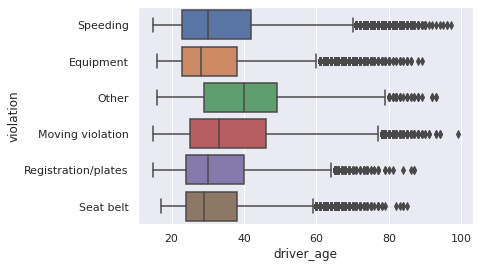

In [ ]:
# boxplot

sns.boxplot('driver_age', 'violation', data=data)

In [ ]:
# beregning beskrivende statistik
data.groupby('violation').driver_age.describe()

,count,mean,std,min,25%,50%,75%,max
violation,,,,,,,,
Equipment,61151.0,31.778041,11.342139,16.0,23.0,28.0,38.0,89.0
Moving violation,89934.0,36.042020,13.115671,15.0,25.0,33.0,46.0,99.0
Other,23548.0,39.756880,13.089626,16.0,29.0,40.0,49.0,93.0
Registration/plates,19805.0,32.722545,11.105843,15.0,24.0,30.0,40.0,87.0
Seat belt,16317.0,32.247717,11.449219,17.0,24.0,29.0,38.0,85.0
Speeding,268191.0,33.484867,12.767760,15.0,23.0,30.0,42.0,97.0


### Anholdelser over tid

* Lav en beregning af gennemsnitlige anholdeser af bilister af forskellige etniciteter per år.

* Lav en lineplot, der visualiserer udviklingen, hue=etnicitet

* hvordan kan det fortolkes?

In [ ]:
# opsamling af data per år

yearly_arrests_per_race = data.groupby('driver_race').resample('Y').is_arrested.mean().reset_index()

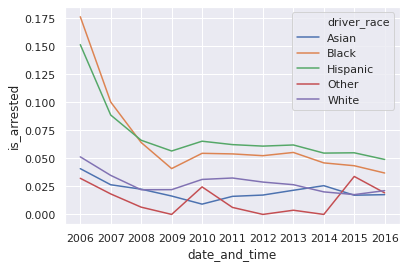

In [ ]:
# lineplot

sns.lineplot(x = yearly_arrests_per_race.date_and_time, y = yearly_arrests_per_race.is_arrested, hue=yearly_arrests_per_race.driver_race)

## Vejrets indflydelse?

er der flere trafikstop, når det er varmere og færre anholdelser under barske vejrforhold?
Her finder du daglige vejrstatistikker fra NOAA (USAs DMI): `https://sds-aau.github.io/IntroStat/Data/RI-weather.csv`

*Dette er en ret avanceret del og mest tænkt som **bonus**. Du kan forvente at møde `merge` til eksamen men ikke en så kompleks kombination af det, tidsserie-index og aggregering.*



* Indlæs vejrdata og lav en tidsserie-index

* Beregn temperatur i celsius og en indikator for ekstreme vejrforhold.

* saml data  ved at bruge *dag* i index som nøgle for din merge.

* ved at bruge merge, taber du tidsserie index - koper index fra `data` og `weather[['temp_celsius','AWND','extreme']]`

Lav en ny dataframe med de kolonner:
* daglig temperatur
* gennemsnitlig vindstyrke
* antal af ekstreme vejrforhold
* antal af stops per dag
* gennsmsnitlige ransagelser
* gennemsnitlige anholdeser per dag


* beregn en korrelationsmatrix of fortolk de største værdier.

In [ ]:
# indlæs data
weather = pd.read_csv('https://sds-aau.github.io/IntroStat/Data/RI-weather.csv')

In [ ]:
# lav tidsserie-index
weather.set_index(pd.to_datetime(weather.DATE), inplace=True)


In [ ]:
# Her defineres en funktion til omregning af fahrenheit til celsius

def fahr_to_celsius(temp_fahr):
    """Convert Fahrenheit to Celsius
    
    Return Celsius conversion of input"""
    temp_celsius = (temp_fahr - 32) * 5 / 9
    return temp_celsius

In [ ]:
# weather['TAVG'] regnes om til celsius
weather['temp_celsius'] = fahr_to_celsius(weather['TAVG'])

In [ ]:
# ekstrem vejr som summe af forskellige kategorier af ekstremvejr WT01 - WT22
weather['extreme'] = weather.loc[:,'WT01':'WT22'].sum(axis='columns')

In [ ]:
# merge af stops of vejrdata
data_w = pd.merge(data, weather[['temp_celsius','AWND','extreme']], left_on=data.index.date, right_on=weather.index.date)

In [ ]:
# hent index tilbage
data_w.index = data.index

In [ ]:
# samling af ny dataframe med per-dag værdier

s1 = data_w.resample('D').size()
s1.name = 'n_stops'
s2 = data_w.resample('D').is_arrested.mean()
s3 = data_w.resample('D').temp_celsius.mean()
s4 = data_w.resample('D').search_conducted.mean()
s5 = data_w.resample('D').extreme.mean()
s6 = data_w.resample('D').AWND.mean()

data_agg = pd.concat([s1,s2,s3,s4,s5,s6], axis=1)

In [ ]:
# beregning korrelationsmatrix
data_agg.corr()

,n_stops,is_arrested,temp_celsius,search_conducted,extreme,AWND
n_stops,1.000000,-0.123760,0.122640,-0.116920,-0.213867,-0.117377
is_arrested,-0.123760,1.000000,-0.058610,0.411924,0.079471,0.029470
temp_celsius,0.122640,-0.058610,1.000000,-0.054477,-0.040765,-0.133814
search_conducted,-0.116920,0.411924,-0.054477,1.000000,0.085202,0.010887
extreme,-0.213867,0.079471,-0.040765,0.085202,1.000000,0.079756
AWND,-0.117377,0.029470,-0.133814,0.010887,0.079756,1.000000
